In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import openpyxl
from openpyxl import load_workbook
import os
import geopandas as gp
import yaml
import math

from scipy.spatial import ConvexHull
from scipy.interpolate import griddata
from shapely.geometry import Point, Polygon

from pykrige.ok import OrdinaryKriging
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from pyproj import Proj

In [2]:
import sys
sys.path.append(r'../tools_F-J/')
from toollib_standard import plotlib
from toollib_standard import mathlib

In [3]:
flag_project = 1 # 0--regular; 1--repartrition

In [4]:
if flag_project == 0:
    file_project = 'a-project.yml'
elif flag_project == 1:
    file_project = 'a-project_repar.yml'
elif flag_project == 2:
    file_project = 'a-project_voro.yml'
    
with open(file_project, 'r', encoding='utf-8') as f:
    proj = yaml.load(f.read(), Loader=yaml.FullLoader)
name_project = proj['name']

#name_project = 'project/output_FJSJ_16-01/'               
#name_project = 'project_repartrition/repartrition_01-03/'               
#name_project = 'project_voronoi/voronoi_01-03/'         

In [5]:
with open('0_config.yml', 'r', encoding='utf-8') as f:
    dir_config = yaml.load(f.read(), Loader=yaml.FullLoader)
dir_project_workspace = dir_config['dir_project_workspace']
dir_CC_workspace = dir_config['dir_CC_workspace']
print('dir_CC_workspace: ', dir_CC_workspace)
print('dir_project_workspace: ', dir_project_workspace)
dir_project = os.path.join(dir_project_workspace, name_project)
print('dir_project: ', dir_project)

dir_CC_workspace:  /shdisk/rem2/Harmon/F-J/San/
dir_project_workspace:  /shdisk/rem2/Harmon/F-J/San/
dir_project:  /shdisk/rem2/Harmon/F-J/San/project_repartition_v4.0/output_repar_v9.2_01-01/


In [6]:
filename = dir_project+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project+'Basic_info.npy'
info_basic_bi = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

In [7]:
dir_model_fund = dir_project + info_basic['rdir_model_fund']
dir_model = dir_project + info_basic['rdir_model']
dir_inv = dir_project + info_basic['rdir_inv_BFGS']
dir_image = dir_project + info_basic['rdir_image']+'Vs_compare/'
if not os.path.exists(dir_image):
    os.makedirs(dir_image)
dir_partition = dir_project + info_basic['rdir_partition']
key_subworks = info_basic['key_subworks']
M = len(key_subworks)
key_subworks

['1--08-03',
 '2--09-03',
 '3--10-03',
 '4--11-03',
 '5--12-03',
 '6--13-03',
 '7--14-03',
 '8--15-03',
 '9--16-03',
 '10--18-03',
 '12--20-03',
 '13--21-03',
 '15--23-03',
 '17--25-03',
 '18--26-03',
 '19--27-03',
 '20--28-03',
 '21--29-03',
 '22--30-03',
 '23--31-03',
 '25--33-03',
 '26--34-03',
 '28--36-03',
 '30--41-03',
 '31--42-03',
 '33--46-03',
 '34--47-03',
 '35--48-03',
 '36--52-03',
 '37--53-03',
 '38--07-04',
 '39--08-04',
 '40--09-04',
 '41--10-04',
 '42--12-04',
 '43--13-04',
 '44--17-04',
 '45--20-04',
 '46--21-04',
 '48--23-04',
 '49--24-04',
 '50--25-04',
 '51--27-04',
 '52--28-04',
 '53--29-04',
 '54--30-04',
 '55--31-04',
 '56--32-04',
 '57--33-04',
 '58--34-04',
 '59--35-04',
 '60--36-04',
 '63--47-04',
 '65--49-04',
 '66--52-04',
 '67--53-04',
 '68--08-05',
 '69--12-05',
 '70--13-05',
 '71--14-05',
 '72--16-05',
 '75--22-05',
 '76--24-05',
 '77--26-05',
 '78--27-05',
 '79--28-05',
 '80--29-05',
 '81--30-05',
 '84--35-05',
 '85--36-05',
 '86--37-05',
 '88--39-05',
 

In [9]:
stalistname_all = info_basic['stalistname_all']
stainfo = pd.read_excel(stalistname_all)
nsta_all = len(stainfo.iloc[:,0])
StationPairs_all = mathlib.GetStationPairs(nsta_all)
nPairs_all = int(len(StationPairs_all)/2)
stalist_all = stainfo['Station'].tolist() 
lat_stations_all =  stainfo['latitude'].tolist() 
lon_stations_all =  stainfo['longitude'].tolist() 
elevation_stations_all = stainfo['elevation'].tolist()

In [10]:
stations_partition = {}
lat_stations_partition = {}
lon_stations_partition = {}
lat_centroid_partition = []
lon_centroid_partition = []
num_stations = []
for key in key_subworks:
    filepath = dir_partition + str(key) + '.txt'
    stations_this, lat_stations_this, lon_stations_this = np.loadtxt(filepath, dtype='str' , unpack=True)
    stations_partition[key] = stations_this
    lat_stations_partition[key] = lat_stations_this.astype(float)
    lon_stations_partition[key] = lon_stations_this.astype(float)
    num_stations.append(len(stations_this))
    lat_centroid_partition.append(np.mean(lat_stations_this.astype(float)))
    lon_centroid_partition.append(np.mean(lon_stations_this.astype(float)))

In [ ]:
faults = np.load('clark_faults.npy', allow_pickle='TRUE').item()

### Interpolate 3D structure

In [ ]:
dz = 3
N = 68
num_x = 100
num_y = 100
type_interp = 'linear'
flag_save = 1 # 1--npz; 2--mat

In [ ]:
# Read all data
struc = {}
struc_fund = {}
flag = 0
for key_subwork in key_subworks:
    file_model = dir_model + 'model_'+key_subwork+'.txt'
    file_model_fund = dir_model_fund + 'model_'+key_subwork+'.txt'
    model = np.loadtxt(file_model)
    model_fund = np.loadtxt(file_model_fund)
    struc[key_subwork] = {}
    struc[key_subwork]['layer'] = model[:, 0]
    struc[key_subwork]['z'] = model[:, 1]
    struc[key_subwork]['rho'] = model[:, 2]
    struc[key_subwork]['vs'] = model[:, 3]
    struc[key_subwork]['vp'] = model[:, 4]
    struc[key_subwork]['std'] = model[:, 5]
    struc_fund[key_subwork] = {}
    struc_fund[key_subwork]['layer'] = model_fund[:, 0]
    struc_fund[key_subwork]['z'] = model_fund[:, 1]
    struc_fund[key_subwork]['rho'] = model_fund[:, 2]
    struc_fund[key_subwork]['vs'] = model_fund[:, 3]
    struc_fund[key_subwork]['vp'] = model_fund[:, 4]
    struc_fund[key_subwork]['std'] = model_fund[:, 5]
    flag += 1
    print('Read structure model: %s (%d/%d)' % (key_subwork, flag, M))

vs_horizon = {}
vs_horizon_fund = {}
for i in range(N):
    vs_horizon[i] = []
    vs_horizon_fund[i] = []
    for key_subwork in key_subworks:
        vs_horizon[i].append(struc[key_subwork]['vs'][i])
        vs_horizon_fund[i].append(struc_fund[key_subwork]['vs'][i])

Read structure model: 1--08-03 (1/466)
Read structure model: 2--09-03 (2/466)
Read structure model: 3--10-03 (3/466)
Read structure model: 4--11-03 (4/466)
Read structure model: 5--12-03 (5/466)
Read structure model: 6--13-03 (6/466)
Read structure model: 7--14-03 (7/466)
Read structure model: 8--15-03 (8/466)
Read structure model: 9--16-03 (9/466)
Read structure model: 10--18-03 (10/466)
Read structure model: 12--20-03 (11/466)
Read structure model: 13--21-03 (12/466)
Read structure model: 15--23-03 (13/466)
Read structure model: 17--25-03 (14/466)
Read structure model: 18--26-03 (15/466)
Read structure model: 19--27-03 (16/466)
Read structure model: 20--28-03 (17/466)
Read structure model: 21--29-03 (18/466)
Read structure model: 22--30-03 (19/466)
Read structure model: 23--31-03 (20/466)
Read structure model: 25--33-03 (21/466)
Read structure model: 26--34-03 (22/466)
Read structure model: 28--36-03 (23/466)
Read structure model: 30--41-03 (24/466)
Read structure model: 31--42-03 (2

In [ ]:
#points = np.column_stack((lon_stations_all, lat_stations_all))
points = np.column_stack((lon_centroid_partition, lat_centroid_partition))
hull = ConvexHull(points)
polygon = Polygon(points[hull.vertices])
index_sta = []
lon_stations_in = []
lat_stations_in = []
elevation_stations_in = []
for i in range(len(lon_stations_all)):
    if polygon.contains(Point(lon_stations_all[i], lat_stations_all[i])):
        index_sta.append(i)
        lon_stations_in.append(lon_stations_all[i])
        lat_stations_in.append(lat_stations_all[i])
        elevation_stations_in.append(elevation_stations_all[i])

In [ ]:
def compute_affine_transform(original_points, target_points):
    A_matrix = np.array([[original_points[0][0], original_points[0][1], 1, 0, 0, 0],
                         [0, 0, 0, original_points[0][0], original_points[0][1], 1],
                         [original_points[1][0], original_points[1][1], 1, 0, 0, 0],
                         [0, 0, 0, original_points[1][0], original_points[1][1], 1],
                         [original_points[2][0], original_points[2][1], 1, 0, 0, 0],
                         [0, 0, 0, original_points[2][0], original_points[2][1], 1]])

    A1_B1_C1 = np.array([target_points[0][0], target_points[0][1], target_points[1][0], target_points[1][1], target_points[2][0], target_points[2][1]])

    coefficients = np.linalg.solve(A_matrix, A1_B1_C1)

    affine_matrix = np.array([[coefficients[0], coefficients[1], coefficients[2]],
                               [coefficients[3], coefficients[4], coefficients[5]],
                               [0, 0, 1]])

    return affine_matrix

In [ ]:
# Affine transformation
lon_stations_all_new = []
lat_stations_all_new = []
for sta in stalist_all:
    if int(sta[1:3]) <= 60:
        lon_stations_all_new.append(lon_stations_all[stalist_all.index(sta)])
        lat_stations_all_new.append(lat_stations_all[stalist_all.index(sta)])
refs = ['R0101','R6001','R6020']
lon_refs = [lon_stations_all[stalist_all.index(ref)] for ref in refs]
lat_refs = [lat_stations_all[stalist_all.index(ref)] for ref in refs]
loc_refs = np.column_stack([lon_refs,lat_refs])
loc_refs_new = np.array([[0,0],[600,0],[600,600]])

affine_matrix = compute_affine_transform(loc_refs, loc_refs_new)

In [ ]:
# all stations
x_stations_all_new = []
y_stations_all_new = []
for i in range(len(lon_stations_all_new)):
    loc_sta = np.array([lon_stations_all_new[i],lat_stations_all_new[i],1])
    loc_sta_new = np.dot(affine_matrix,loc_sta)
    x_stations_all_new.append(loc_sta_new[0])
    y_stations_all_new.append(loc_sta_new[1])
# in stations
x_stations_in = []
y_stations_in = []
for i in range(len(lon_stations_in)):
    loc_sta = np.array([lon_stations_in[i],lat_stations_in[i],1])
    loc_sta_new = np.dot(affine_matrix,loc_sta)
    x_stations_in.append(loc_sta_new[0])
    y_stations_in.append(loc_sta_new[1])
# faults
x_faults = {}
y_faults = {}
for i in range(len(faults)):
    x_faults['clark'+str(i+1)] = []
    y_faults['clark'+str(i+1)] = []
    for j in range(len(faults['clark'+str(i+1)]['lon'])):
        loc_fault = np.array([faults['clark'+str(i+1)]['lon'][j],faults['clark'+str(i+1)]['lat'][j],1])
        loc_fault_new = np.dot(affine_matrix,loc_fault)
        x_faults['clark'+str(i+1)].append(loc_fault_new[0])
        y_faults['clark'+str(i+1)].append(loc_fault_new[1])
# partitions
x_centroid_partition = []
y_centroid_partition = []
for i in range(len(lon_centroid_partition)):
    loc_centroid = np.array([lon_centroid_partition[i],lat_centroid_partition[i],1])
    loc_centroid_new = np.dot(affine_matrix,loc_centroid)
    x_centroid_partition.append(loc_centroid_new[0])
    y_centroid_partition.append(loc_centroid_new[1])

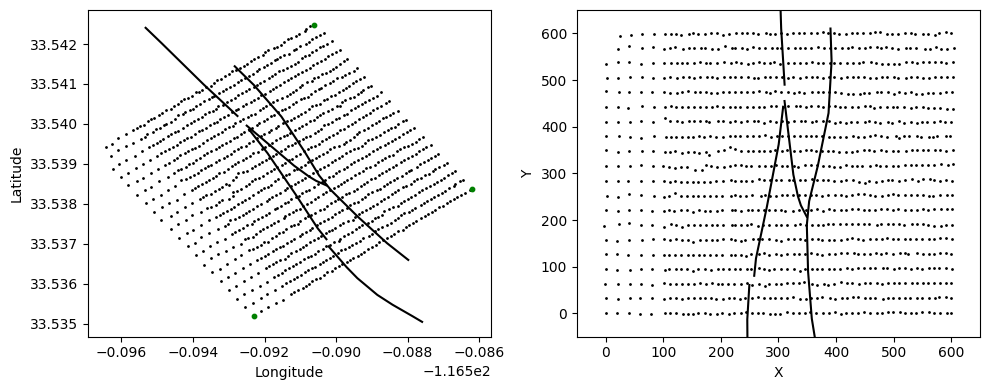

In [ ]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)
ax.scatter(lon_stations_all_new, lat_stations_all_new, c='k', label='Original',s = 1)
for ref in refs:
    ax.scatter(lon_stations_all[stalist_all.index(ref)], lat_stations_all[stalist_all.index(ref)], c='g', label='Original',s = 10)
for i in range(len(faults)):
    ax.plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'k')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax = fig.add_subplot(122)
ax.scatter(x_stations_all_new, y_stations_all_new, c='k', label='Original',s = 1)
for i in range(len(faults)):
    ax.plot(x_faults['clark'+str(i+1)], y_faults['clark'+str(i+1)], 'k')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim(-50,650)
ax.set_ylim(-50,650)
plt.tight_layout()

### Interpolate

In [ ]:
# generate grid
xx = np.linspace(np.min(x_centroid_partition), np.max(y_centroid_partition), num_x)
yy = np.linspace(np.min(y_centroid_partition), np.max(y_centroid_partition), num_y)
A,B = np.meshgrid(xx, yy)
X_star = np.hstack((A.flatten()[:,None], B.flatten()[:,None]))
x_grid = X_star[:,0]
y_grid = X_star[:,1]

points = np.column_stack((x_centroid_partition, y_centroid_partition))
hull = ConvexHull(points)
polygon = Polygon(points[hull.vertices])
index = []
x_inter_in = []
y_inter_in = []
for i in range(len(x_grid)):
    if polygon.contains(Point(x_grid[i], y_grid[i])):
        index.append(i)
        x_inter_in.append(x_grid[i])
        y_inter_in.append(y_grid[i])

In [ ]:
vs_inter_fund_horizon_in = np.zeros((N,len(index)))
vs_inter_horizon_in = np.zeros((N,len(index)))
ele_inter = np.zeros((N,len(index)))
for i in range(N):
    print('Interpolating horizon %d/%d' % (i+1,N))
    OK = OrdinaryKriging(x_centroid_partition, y_centroid_partition, vs_horizon[i], variogram_model=type_interp,nlags=3)
    zz,ss = OK.execute('grid', xx, yy)
    vs_inter_horizon_in[i,:] = zz.reshape(len(xx)*len(yy))[index]
    OK = OrdinaryKriging(x_centroid_partition, y_centroid_partition, vs_horizon_fund[i], variogram_model=type_interp,nlags=3)
    zz,ss = OK.execute('grid', xx, yy)
    vs_inter_fund_horizon_in[i,:] = zz.reshape(len(xx)*len(yy))[index]
OK = OrdinaryKriging(x_stations_in, y_stations_in, elevation_stations_in, variogram_model=type_interp,nlags=3)
zz,ss = OK.execute('grid', xx, yy)
ele_inter = zz.reshape(len(xx)*len(yy))[index]

Interpolating horizon 1/68
Interpolating horizon 2/68
Interpolating horizon 3/68
Interpolating horizon 4/68
Interpolating horizon 5/68
Interpolating horizon 6/68
Interpolating horizon 7/68
Interpolating horizon 8/68
Interpolating horizon 9/68
Interpolating horizon 10/68
Interpolating horizon 11/68
Interpolating horizon 12/68
Interpolating horizon 13/68
Interpolating horizon 14/68
Interpolating horizon 15/68
Interpolating horizon 16/68
Interpolating horizon 17/68
Interpolating horizon 18/68
Interpolating horizon 19/68
Interpolating horizon 20/68
Interpolating horizon 21/68
Interpolating horizon 22/68
Interpolating horizon 23/68
Interpolating horizon 24/68
Interpolating horizon 25/68
Interpolating horizon 26/68
Interpolating horizon 27/68
Interpolating horizon 28/68
Interpolating horizon 29/68
Interpolating horizon 30/68
Interpolating horizon 31/68
Interpolating horizon 32/68
Interpolating horizon 33/68
Interpolating horizon 34/68
Interpolating horizon 35/68
Interpolating horizon 36/68
I

### Save

In [ ]:
# save as npz
z = np.arange(0,N*dz,dz)
if flag_save == 1:
    print('Save as npz')
    filename = dir_inv + 'vs_inter.npz'
    if os.path.exists(filename):
        os.remove(filename)
    # save as npz
    np.savez(filename,ele = ele_inter,vs_fund = vs_inter_fund_horizon_in,vs = vs_inter_horizon_in, x = x_inter_in,y = y_inter_in, depth = z,dz=dz,N=N)

Save as npz
